In [43]:
import torchosr

In [44]:
from torchvision import transforms
data = torchosr.data.base_datasets.MNIST_base(root='data', 
                                              download=True, 
                                              transform=transforms.Compose([
                                                transforms.Resize(28),
                                                transforms.ToTensor()]))
data

Dataset MNIST_base
    Number of datapoints: 70000
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [45]:
config, openness = torchosr.data.configure_division(data, 
                                                    n_openness=3, 
                                                    repeats=3, 
                                                    seed=1234)

for i, (kkc, uuc) in enumerate(config):
    print('C%i - Op: %.3f KKC:%s \t UUC:%s' % (
        i, 
        openness[int(i/3)].detach().numpy(), 
        kkc.detach().numpy(), 
        uuc.detach().numpy()))

C0 - Op: 0.047 KKC:[0 1 7 9 3] 	 UUC:[6]
C1 - Op: 0.047 KKC:[6 4 9 2 7] 	 UUC:[1]
C2 - Op: 0.047 KKC:[1 6 7 0 5] 	 UUC:[9]
C3 - Op: 0.225 KKC:[8 4 5] 	 UUC:[3 1 9 6]
C4 - Op: 0.225 KKC:[9 7 4] 	 UUC:[2 5 0 8]
C5 - Op: 0.225 KKC:[0 4 2] 	 UUC:[3 9 6 8]
C6 - Op: 0.397 KKC:[3 6] 	 UUC:[9 1 4 0 8 7 5]
C7 - Op: 0.397 KKC:[2 5] 	 UUC:[9 8 6 3 1 4 7]
C8 - Op: 0.397 KKC:[4 1] 	 UUC:[3 0 5 9 2 7 8]


In [46]:
from torch.utils.data import DataLoader

kkc, uuc = config[0]
train_data, test_data = torchosr.data.get_train_test(data,
                                                   kkc, uuc,
                                                   root = 'data',
                                                   tunning = False,
                                                   fold = 0,
                                                   seed = 1234,
                                                   n_folds = 5)

train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=True)



In [47]:
import numpy as np

X, y = next(iter(train_data_loader))
print('Train labels:', np.unique(np.argmax(y, axis=1)))
    
X, y = next(iter(test_data_loader))
print('Test labels:', np.unique(np.argmax(y, axis=1)))


Train labels: [0 1 2 3 4]
Test labels: [0 1 2 3 4 5]


In [52]:
method = torchosr.models.TSoftmax(lower_stack=torchosr.architectures.fc_lower_stack(depth=1, img_size_x=28, n_out_channels=64),
                                n_known=len(kkc),
                                epsilon=torchosr.utils.base.get_softmax_epsilon(len(kkc)))

In [56]:
import torch

# Specify processing parameters
epochs = 128
learning_rate = 1e-3

# Prepare array for results
results = torch.zeros((4,epochs))

# Initialize loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.SGD(method.parameters(), lr=learning_rate)

for t in range(epochs):
    # Train
    method.train(train_data_loader, loss_fn, optimizer)
    
    # Test
    inner_score, outer_score, hp_score, overall_score = method.test(test_data_loader, loss_fn)
    results[:, t] = torch.tensor([inner_score, outer_score, hp_score, overall_score])
                    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


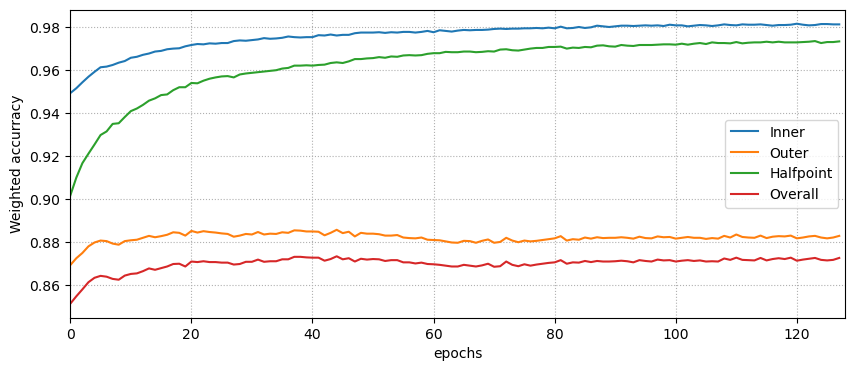

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(results.T, label=['Inner', 'Outer', 'Halfpoint', 'Overall'])
ax.legend()
ax.grid(ls=':')
ax.set_xlabel('epochs')
ax.set_ylabel('Weighted accurracy')
ax.set_xlim(0,epochs)

plt.savefig('example.png')
plt.savefig('example.eps')

In [81]:
inner_score, outer_score, hp_score, overall_score, \
    inner_c, outer_c, hp_c, overall_c = method.test(test_data_loader, loss_fn, conf=True)
print(overall_c.detach().numpy())

[[1244    2    1    1    3   12]
 [   1 1406    6    2    1   12]
 [   1    2 1240    6    3   25]
 [   0    5    5 1303    7   25]
 [   5    4   18    7 1206   22]
 [ 367  111   76   14  250  411]]
